# Julia ecosystems of scientific computing

There are many Julia organizations about seemingly every scientific area. Some examples:

- Astrophysics: [JuliaAstro](https://juliaastro.github.io/), [JuliaSpace](https://github.com/JuliaSpace)
- Bio/Chemistry: [JuliaBio](https://biojulia.net/), [Molecular simulations](https://github.com/JuliaMolSim)
- Complex systems, nonlinear dynamics: [JuliaDynamics](https://juliadynamics.github.io/JuliaDynamics/)
- Differential equations: [JuliaDiffEq](https://juliadiffeq.org/)
- Solid state: [QuantumOptics](https://qojulia.org/), [JuliaPhysics](https://github.com/JuliaPhysics)
- Economics: [QuantEcon](https://julia.quantecon.org/), [JuliaQuant](https://github.com/JuliaQuant)
- Geosciences/Climate: [JuliaGeo](https://github.com/JuliaGeo), [JuliaEarth](https://github.com/JuliaEarth), [JuliaClimate](https://github.com/JuliaClimate).

among many many others, not even mentioning mathematics-focused organizations like nonlinear optimization, etc....


In this last session I will (**very briefly**) overview some powerful Julia packages I found useful for *my own work* and hopefully you will too. Even if the packages relevant for me are not useful in your field, it is still good practice to solve the exercises, to "learn how to learn Julia packages". 

*Quick note: I use `PyPlot` (the matplotlib package of Python) to plot, because it is super-duper powerful. All Python packages are immediately and directly usable in Julia with exactly same syntax as Python (besides the indexing thingy: Julia indices start from 1.*

In [1]:
using PyPlot
# set default figure size:
PyPlot.rc("figure", figsize = (5, 3))
# enable 3D plotting
using3D()


# 1. DifferentialEquations.jl

[DifferentialEquations.jl](https://docs.juliadiffeq.org/latest/) is by far [the best](https://www.stochasticlifestyle.com/comparison-differential-equation-solver-suites-matlab-r-julia-python-c-fortran/) free and open source differential equations solver (not for Julia, for any language). It can solve standard ODEs, Delay-DEs, stochastic DEs, has tools for PDEs, event handling, other multiple features, 100s of solvers, and *even more*.

Here we will focus on ODEs and use the module `OrdinaryDiffEq` only.

## Defining and solving some ODEs

The way DifferentialEquations.jl works is quite straightforward:

1. Make your set of ODEs a Julia function `f`
2. Put `f`, an initial state and a parameter container into an `ODEProblem`.
2. Choose the solvers and the arguments of the solvers you will use (e.g. tolerances, etc.)
3. Give `f` as well as the auxiliary arguments to the function `solve`!

Let's see it in practice by solving the Lorenz system

$$
\begin{aligned}
\dot{x} &= \sigma (y - x) \\
\dot{y} &= x (\rho - z) - y \\
\dot{z} &= xy -\beta z
\end{aligned}
$$

First step is to make this a Julia function. There is some strictness when writing this function in Julia (to play well with another software, see below). 
Specifically, it can only be one of two forms: out-of-place (oop) or in-place (iip). Here is how to define it (`p` is the parameter container, `t` is time):

* **oop** : The `eom` function must be in the form `eom(x, p, t) -> SVector`
  which means that given a state `x::SVector` it returns an [`SVector`](http://juliaarrays.github.io/StaticArrays.jl/stable/pages/api.html#SVector-1)
  (from the [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) module)
  containing the derivatives.
* **iip** : The `eom` function must be in the form `eom!(dx, x, p, t)`
  which means that given a state `x::Vector` it writes in-place the derivatives in `dx`.

We advise to use **oop** for systems with dimension ≤ 10, and use **iip** otherwise.

In [85]:
using OrdinaryDiffEq, StaticArrays

function lorenz_rule(u, p, t)
    σ, ρ, β = p
    x, y, z = u
    dx = σ*(y - x)
    dy = x*(ρ-z) - y
    dz = x*y - β*z
    return SVector(dx, dy, dz)
end

lorenz_rule (generic function with 1 method)

Then set the initial state and parameter container

In [3]:
u₀ = SVector(10.0, 10.0, 10.0)
p₀ = [10, 28, 8/3]

3-element Array{Float64,1}:
 10.0               
 28.0               
  2.6666666666666665

then put everything into the `ODEProblem` structure:

In [4]:
# third argument is the timespan to solve in
prob = ODEProblem(lorenz_rule, u₀, (0.0, 100.0), p₀)

ODEProblem with uType SArray{Tuple{3},Float64,1,3} and tType Float64. In-place: false
timespan: (0.0, 100.0)
u0: [10.0, 10.0, 10.0]

Alright, so now we choose the solver to use

In [5]:
alg = Vern9() # 9-th order adaptive solver

Vern9(true)

Now let's solve the Lorenz system using the default settings of DifferentialEquations.jl (without specifying anything else).

In [6]:
sol = solve(prob; alg = alg)

retcode: Success
Interpolation: specialized 9th order lazy interpolation
t: 902-element Array{Float64,1}:
   0.0                
   0.09355226310426   
   0.17283944628206213
   0.24997046635545134
   0.33111610744803827
   0.42743131783646965
   0.5201140913658462 
   0.6242605175854586 
   0.7340052492650533 
   0.8380149776590866 
   0.9438866257985115 
   1.0545811111840224 
   1.1789855148275294 
   ⋮                  
  98.86131214292969   
  98.966663437393     
  99.07194022267977   
  99.19597178668509   
  99.33755089044504   
  99.44051282392593   
  99.54192389117195   
  99.62958862392502   
  99.74154878708663   
  99.84341219700966   
  99.96495889802289   
 100.0                
u: 902-element Array{SArray{Tuple{3},Float64,1,3},1}:
 [10.0, 10.0, 10.0]                                             
 [14.527288897352587, 21.12071452189923, 24.655401013820843]    
 [16.260683509932253, 11.98774098852595, 40.866652625646566]    
 [9.410451093456127, -1.345343845837725, 37.613

Okay, so what is the returned result? We didn't specify when to save or anything...

The solver we chose, `Vern9` (also true for the default solver) is an adaptive step solver. The system is evolved with adaptive step, until we reach the end of the time span. A state is recorded at every step. E.g. the solution at the third step is 

In [7]:
(sol.t[3], sol.u[3])

(0.17283944628206213, [16.260683509932253, 11.98774098852595, 40.866652625646566])

And using the syntax `sol[i, j]` we can access the `i` variable at the `j`-th time point

In [8]:
sol[1, 3]

16.260683509932253

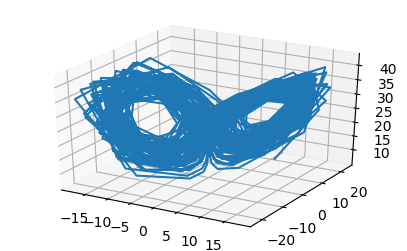

In [9]:
plot3D(sol[1, :], sol[2, :], sol[3, :]);

Because of the mechanics of the solver, `sol` object allows arbitrary interpolation in time by saving some extra derivative-related numbers. This means that we can use `sol` as a function of time, `sol(t)`:

In [10]:
sol(5.6)

3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
  0.815736398746072 
 -2.6297520921486752
 25.431305588918814 

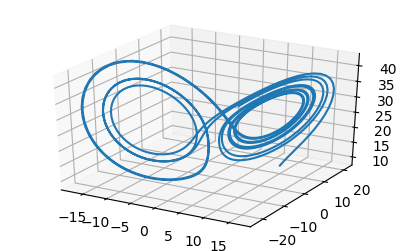

In [11]:
t = 0:0.01:10
X, Y, Z = zero(t), zero(t), zero(t)
for (i, τ) in enumerate(t)
    X[i], Y[i], Z[i] = sol(τ)
end
plot3D(X, Y, Z);

Notice that it is possible to skip this advanced feature of interpolation (and thus also skip collecting the extra interpolation-related numbers) and only save at some pre-defined time points by passing the extra argument `saveat = [points I want]`.

## Numbers with uncertainty

The module `Measurements` provide numeric types that have error bars; so that your numeric operations propagate the errors as is done in experimental physics.

Without any effort, you can solve a differential equation of numbers with error bars! And your solution will itself be a sequence of numbers with properly calculated errorbars.

* How does this happen? Because `OrdinaryDiffEq` uses internally standard mathematical operations on numbers to solve an ODE. 
* `Measurements` defines a number type (`Measurement`, not that different from the `RationalNumber` you defined in a previous exercise). This number naturally supports arithmetics on `+, -, *,...` etc. on numbers with errors.

Let's see how `Measurements` works:

In [12]:
using Measurements

In [13]:
x = 0.5 ± 0.1 # \pm<TAB> = ±

0.5 ± 0.1

In [14]:
typeof(x)

Measurement{Float64}

In [15]:
(sqrt(x) - 3) * (4 ± 1)

-9.2 ± 2.3

Okay let's revisit now the Lorenz problem, but initialize it with a state that has `Measurement` as its number type

In [16]:
uunc = SVector(10.0 ± 0.1, 10.0 ± 0.1, 10.0 ± 0.1)
# notice we could also add errors to parameters p₀

3-element SArray{Tuple{3},Measurement{Float64},1,3} with indices SOneTo(3):
 10.0 ± 0.1
 10.0 ± 0.1
 10.0 ± 0.1

In [17]:
probunc = ODEProblem(lorenz_rule, uunc, (0.0, 10.0), p₀)

ODEProblem with uType SArray{Tuple{3},Measurement{Float64},1,3} and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: Measurement{Float64}[10.0 ± 0.1, 10.0 ± 0.1, 10.0 ± 0.1]

In [18]:
solunc = solve(probunc; alg = alg)

retcode: Success
Interpolation: specialized 9th order lazy interpolation
t: 122-element Array{Float64,1}:
  0.0                
  0.13234363885533806
  0.21267992404209823
  0.29337792152226183
  0.377346397107085  
  0.4634969826202153 
  0.5466201560209227 
  0.6341784834884603 
  0.7219957607908694 
  0.80704728617099   
  0.8926799958261173 
  0.9727071726523201 
  1.0567175506211872 
  ⋮                  
  9.123000369387853  
  9.205257719137007  
  9.28304739339006   
  9.362874619555148  
  9.44713675740573   
  9.524040468207755  
  9.603166507716589  
  9.683639775594193  
  9.768834133488447  
  9.856926418552634  
  9.93911524402789   
 10.0                
u: 122-element Array{SArray{Tuple{3},Measurement{Float64},1,3},1}:
 [10.0 ± 0.1, 10.0 ± 0.1, 10.0 ± 0.1]            
 [16.506 ± 0.063, 19.38 ± 0.11, 34.17 ± 0.22]    
 [13.346 ± 0.079, 3.63 ± 0.19, 41.119 ± 0.075]   
 [5.124 ± 0.098, -3.537 ± 0.091, 32.742 ± 0.093] 
 [0.086 ± 0.078, -3.643 ± 0.073, 25.565 ± 0.06]  
 [-2.

Notice that *obviously* trying to solve a chaotic system with such huge errors will diverge... No matter though, let's see the solution anyway.

In [19]:
t = 0:0.05:5
Xunc = [solunc(τ)[1] for τ in t]

101-element Array{Measurement{Float64},1}:
   10.0 ± 0.1  
 11.658 ± 0.083
 14.942 ± 0.082
 16.761 ± 0.048
 14.501 ± 0.066
   9.41 ± 0.1  
  4.565 ± 0.096
  1.277 ± 0.083
 -0.663 ± 0.076
 -1.835 ± 0.079
 -2.724 ± 0.089
  -3.67 ± 0.11 
   -4.9 ± 0.13 
        ⋮      
    9.9 ± 3.4  
   12.7 ± 2.1  
   14.3 ± 1.1  
   13.4 ± 4.1  
   10.3 ± 4.6  
    6.7 ± 3.0  
    4.0 ± 1.0  
    2.3 ± 0.55 
    1.4 ± 1.7  
    1.1 ± 2.6  
    1.0 ± 3.6  
    1.2 ± 4.9  

In [20]:
Xv = Measurements.value.(Xunc) # get values (broadcasting)
Xe = Measurements.uncertainty.(Xunc) # get errors

101-element Array{Float64,1}:
 0.1                
 0.08342714456816318
 0.08243145121464032
 0.04765367655591914
 0.0663485293647113 
 0.1003943815025594 
 0.09643886077929786
 0.08309413890388685
 0.07640955696024836
 0.07864193098067553
 0.08891403394179949
 0.1068415764868824 
 0.13156908343006712
 ⋮                  
 3.437099774976129  
 2.0540397206706342 
 1.0879109371031364 
 4.094594616200674  
 4.576490135852936  
 2.9816543947907004 
 1.00086937886618   
 0.5510702440924684 
 1.6544674631819647 
 2.56281860734045   
 3.5545242140327025 
 4.900933699218517  

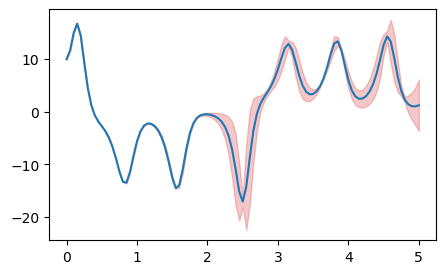

In [21]:
# plot errors nicely
plot(t, Xv)
fill_between(t, Xv .- Xe, Xv .+ Xe, color = "C3", alpha = 0.25);

My guess is that you could probably/maybe get something like this in Python with a lot of effort. The case of Julia here is unbelievably cool because:

1. `Measurements` has never written any code that solves a differential equation.
2. `OrdinaryDiffEq` has never written any code that controls how an error is propagated.
3. There isn't any boilerplate code "connecting" the two packages.

## Event handling

DifferentialEquations.jl implements a simple API so that "events" (arbitrary things) happen to your solution as it is progressing in time. This is done with the [`Callback` interface](https://docs.juliadiffeq.org/latest/features/callback_functions/#callbacks-1). For example, a `ContinuousCallback` represents an event that "triggers" when a continuous univariate function reaches the value `0`. Similarly, a `DiscreteCallback` triggers when a boolean function evaluates to `true`.

Let's modify the Lorenz problem with a callback. For the callback we need to define a `condition` function, and also an `affect!` function, that says what happens once the callback is triggered.

In [22]:
condition(u, t, integrator) = u[2]

condition (generic function with 1 method)

In [23]:
function affect!(integrator)
    u = integrator.u
    integrator.u = (u[1], u[2], 0.9u[3])
end

affect! (generic function with 1 method)

In [24]:
cb = ContinuousCallback(condition, affect!);

Recall the `prob` definition:

In [25]:
prob = ODEProblem(lorenz_rule, u₀, (0.0, 10.0), p₀)

ODEProblem with uType SArray{Tuple{3},Float64,1,3} and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: [10.0, 10.0, 10.0]

In [26]:
sol = solve(prob; alg = Vern9(), callback = cb);

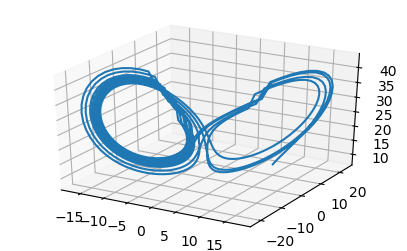

In [27]:
t = 0:0.01:10
X, Y, Z = zero(t), zero(t), zero(t)
for (i, τ) in enumerate(t)
    X[i], Y[i], Z[i] = sol(τ)
end
plot3D(X, Y, Z);

# 2. DynamicalSystems.jl
[DynamicalSystems.jl](https://juliadynamics.github.io/DynamicalSystems.jl/dev/) is an award-winning library for nonlinear dynamics and chaos. 

*Disclaimer: I am one of the developers of this library.*

Around 1/3 of the functionality of DynamicalSystems.jl treats systems with known rule $f$, and directly uses this rule to evolve the state space and the tangent space (the linearized dynamics). DynamicalSystems.jl builds on top of DifferentialEquations.jl to evolve systems in time. The rest of the functionality treats timeseries directly, doesn't matter where you got em from.

## Using known rule $f$

If you have a dynamical system where you know its rule $f$, there are a lot of things you can do with in DynamicalSystems.jl. But for all of them, step 1 is to make this rule $f$ into a `DynamicalSystem` instance. The process here is almost identical to DifferentialEquations.jl:

1. Make $f$ a Julia function (using the same syntax as in DifferentialEquations.jl).
2. Choose initial state and parameter container (again same as DiffEq).
3. Pass these arguments to the `ContinuousDynamicalSystem` constructor (or `DiscreteDynamicalSystem`, for discrete systems).

Here we already have `lorenz_rule, u₀, p₀` defined, so the process  is kind of trivial:

In [28]:
using DynamicalSystems
lorenz = ContinuousDynamicalSystem(lorenz_rule, u₀, p₀)

3-dimensional continuous dynamical system
 state:       [10.0, 10.0, 10.0]
 e.o.m.:      lorenz_rule
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [10.0, 28.0, 2.6666666666666665]

Then you can use this `lorenz` object in various functions of the library. For example, to obtain the Lyapunov spectrum you use `lyapunovs`:

In [29]:
lyapunovs(lorenz, 10000) # 2nd argument is for how much time to evolve

3-element Array{Float64,1}:
   0.9040593406250697    
  -0.00020020892167364334
 -14.570501871732901     

Same story happens if you want to get only the maximum Lyapunov exponent. You use the function `lyapunov` (which uses a different algorithm):

In [30]:
lyapunov(lorenz, 10000.0)

0.9056913975220796

Or, obtain a Poincare surface of section with the plane that e.g. the $y$ variable crosses zero:

In [31]:
plane = (2, 0.0) # plane[1]: which variable, plane[2]: which value
psos = poincaresos(lorenz, (2, 0.0), 1000.0)

3-dimensional Dataset{Float64} with 476 points
  -7.10792   -3.66265e-7   33.0688
 -11.5291    -3.14584e-9   40.5135
   2.24303   -6.15224e-12  24.2377
  -7.09758   -2.29198e-7   33.0521
 -11.5026    -1.91843e-9   40.4678
   1.97185    2.285e-9     23.6029
  -6.36179   -1.0439e-6    31.8233
 -10.1942    -2.49149e-9   38.2322
   3.34247    2.59029e-6   26.5141
  -8.63591   -1.86515e-7   35.614 
  -7.42905   -3.67076e-7   33.604 
 -12.9019    -4.30439e-10  42.9089
   0.36134   -1.21471e-10  17.5907
   ⋮                              
  -8.64694   -2.2795e-7    35.6321
  -7.49088   -4.44474e-7   33.7069
 -13.8631    -1.37158e-8   44.6206
  -9.88093   -1.15107e-7   37.7025
   1.48638   -9.72846e-10  22.338 
  -8.1977    -1.90012e-7   34.883 
  -7.58548   -3.62746e-8   33.8638
  -5.36086   -4.32412e-7   30.1306
  -9.28587   -6.20987e-8   36.7013
 -10.6931     1.32382e-8   39.0799
   0.763925  -2.1828e-10   19.8526
  -6.70268   -3.30653e-7   32.3929

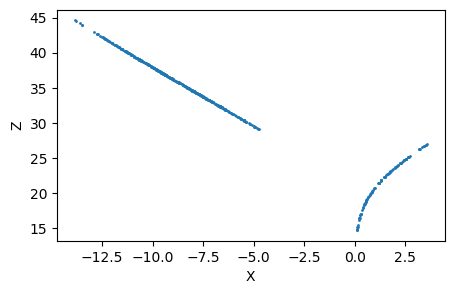

In [32]:
scatter(psos[:, 1], psos[:, 3], s = 1);
xlabel("X"); ylabel("Z");

## Nonlinear timeseries analysis

Both basic as well as advanced tools for nonlinear timeseries analysis are included in DynamicalSystems.jl. To spare you the boredom I won't talk about them though! I'll only mention entropy, because it is relevant to one of the exercises. Let's say that you have a nice trajectory sampled at discrete times (which is what the function `trajectory` does).

In [33]:
tr = trajectory(lorenz, 1000.0; dt = 0.05)

3-dimensional Dataset{Float64} with 20001 points
  10.0         10.0       10.0   
  11.6604      17.4659    15.75  
  14.9431      21.227     26.2311
  16.7587      16.6772    37.8091
  14.4989       6.06744   41.6612
   9.40731     -1.34788   37.6097
   4.5647      -3.65188   32.0526
   1.27841     -3.76227   27.5651
  -0.660687    -3.58262   24.0887
  -1.83235     -3.75926   21.3038
  -2.72165     -4.46127   19.0841
  -3.66336     -5.7684    17.464 
  -4.89541     -7.77907   16.6366
   ⋮                             
  -8.7667     -14.7776    16.5172
 -11.9634     -18.3725    22.6565
 -14.5968     -17.9932    31.5653
 -14.751      -11.7214    38.2464
 -11.8535      -4.01615   38.369 
  -7.72111      0.296008  34.3243
  -4.24419      1.48778   29.7596
  -1.98705      1.41035   25.8345
  -0.714311     1.11662   22.5334
  -0.0343316    0.956168  19.7044
   0.357267     0.996214  17.2529
   0.654459     1.24426   15.126 

The above result is not a `Matrix`, but a vector-of-vectors (for performance purposes). This `tr` represents in fact the attractor of the Lorenz system, since this is what we just evolved in time. Typically one is interested in the entropy of this attractor, by partitioning the state space in boxes of size `ε` (it will become apparent in a bit why).

You can get this entropy (of order α) using the function `genentropy(α, ε, tr)`:

In [34]:
H = genentropy(1, 0.1, tr)

9.837529474680585

In [35]:
H = genentropy(1, 0.01, tr)

9.90353755128635

This quantity is interesting because it can be used to calculate the fractal dimension of the `tr` object. The way it works is simple: You look at how `H` changes for varying `ε`. If `D` is the fractal dimension of `tr`, then it typically holds that `H ~ ε^(-D)`. 

In reality what one does is calculate `H` for many different `ε` and plot the result, and then _manually_ identify the slope of the curve `H` vs. `-log(ε)`. e.g.:

In [36]:
εs = ℯ .^ (-8:0.5:8) # \euler<TAB} = ℯ
Hs = genentropy.(1, εs, Ref(tr))

33-element Array{Float64,1}:
  9.90353755128635  
  9.90353755128635  
  9.90353755128635  
  9.90353755128635  
  9.90353755128635  
  9.90353755128635  
  9.90353755128635  
  9.90353755128635  
  9.90312168377139  
  9.900557167429135 
  9.891269459595035 
  9.860042707793426 
  9.78074383756112  
  ⋮                 
  2.702396852726326 
  1.9641564466046155
  0.821385539477985 
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               
 -0.0               

What we did above is use broadcasting (the `.` syntax), to calculate the entropy for every `ε` value. What's with the `Ref()`? This `Ref()` specifies that its argument `tr` should **not** be broadcasted over. Since both `ε` as well as `tr` are iterable, Julia would normally try to broadcast across both arguments, which we don't want in this case.

Anyway, this is the plot:

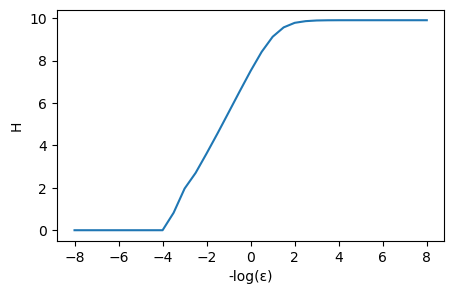

In [37]:
xs = -log.(εs)
plot(xs, Hs)
xlabel("-log(ε)"); ylabel("H");

And one can clearly identify a region in the middle which has the slope of `D`, the fractal dimension of `tr`. But in case you are not really happy with eyeballing this, you can use the function `linear_regions(x, y)` which takes in the curve `y(x)` and decomposes it to approximately independent linear regions.

Let's see the result with some nice color coding:

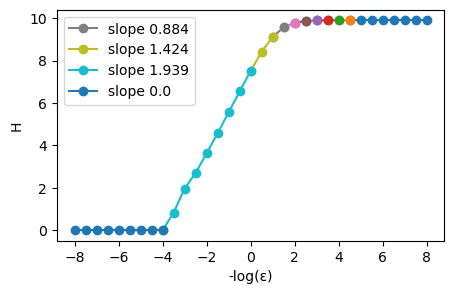

In [38]:
lrs, slopes = linear_regions(xs, Hs, tol = 0.25)

for i in 1:length(lrs)-1
    plot(xs[lrs[i]:lrs[i+1]], Hs[lrs[i]:lrs[i+1]], marker = "o", 
        label = i > 7 ? "slope $(round(slopes[i]; digits = 3))" : "")
end
xlabel("-log(ε)"); ylabel("H"); legend();

So here we would get the value `1.939` as the fractal dimension, which is easily accessible as 

In [39]:
D = maximum(slopes)

1.9387874361172148

# 3. Distributions.jl

The [`Distributions`](https://juliastats.org/Distributions.jl/stable/) package provides an interface for writing distribution-agnostic code: sampling distributions and getting pdfs, using moments, and more. This means that you can write any code that uses a probability distribution without having to care about the distribution's specifics. The result: your code can be run with _any_ probability distribution!

The way it works is quite straightforward: `Distributions` provides a unified API around abstract types representing probability distributions. To keep things simple here we (a) limit ourselves to univariate distributions and (b) assume that the highest level of this abstract hierarchy is `UnivariateDistribution`.

In [40]:
using Distributions
x = -1:0.01:1
UnivariateDistribution

Distribution{Univariate,S} where S<:ValueSupport

Here are some example univariate distributions:

In [41]:
d = Normal(0.1, 0.25)

Normal{Float64}(μ=0.1, σ=0.25)

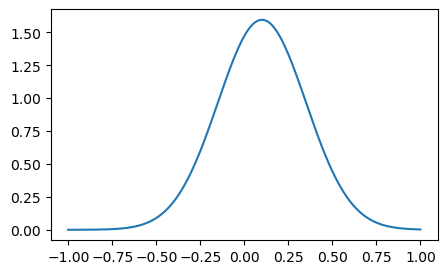

In [42]:
plot(x, pdf.(d, x)); # pdf(::Distribution, x) gives the pdf at x

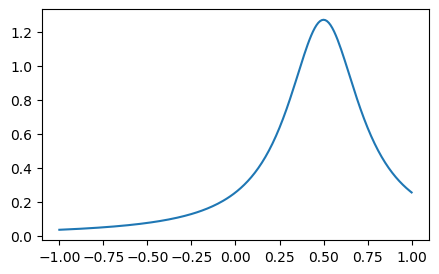

In [43]:
cauchy = Cauchy(0.5, 0.25)
plot(x, pdf.(cauchy, x));

You can also create your own distribution by extending a small amount of methods. 

Okay, so where are these distributions useful? Well, you can for example use `rand(::Distribution, ...)` and sample random numbers from an arbitrary distribution:

In [44]:
rand(cauchy)

0.6411208610416594

In [45]:
rand(cauchy, 10, 10)

10×10 Array{Float64,2}:
 -0.0945251   0.684076  0.466336   …  0.422561   0.522409   -1.76902 
  4.8943     -1.42156   0.533809      0.659961   0.500381    0.339564
  0.496773    1.76202   0.623583      1.38527    0.509958    0.476158
  0.153889    0.309391  0.706236      0.526716  -0.658566  -31.2724  
  1.18274     0.938097  0.49508       0.553075   0.313847    0.34469 
  0.619908    0.4957    0.349988   …  2.06727    0.355546    0.848048
  0.52721     0.247744  0.477669      0.772037   0.93203     0.511023
  0.214352    0.83484   2.49486       0.404149   0.834677    0.753976
  0.352015    2.12321   0.690749      0.186116   0.644478    0.414438
  0.739386    0.366461  0.0252278     0.229541   1.4945     -1.28772 

Or, you can use the `fit` function, to fit a distribution to an e.g. experimental measurement:

In [46]:
x = randn(5000);
fit(Normal, x)

Normal{Float64}(μ=-0.008417643639840577, σ=0.9899834868193246)

In [47]:
cauchyfit = fit(Cauchy, x)

Cauchy{Float64}(μ=-0.006922149389176409, σ=0.6748085966702937)

In [48]:
params(cauchyfit)

(-0.006922149389176409, 0.6748085966702937)

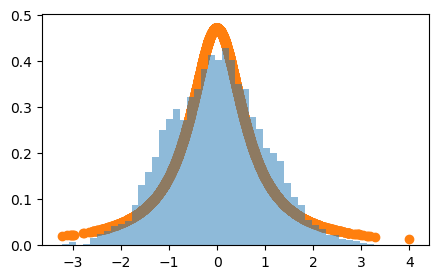

In [49]:
hist(x, 50, alpha = 0.5, density = true)
scatter(x, pdf.(cauchyfit, x), color = "C1");

Of course, other fundamental statistical measures, e.g. means, stds, quantiles, work out of the box for any distribution

In [50]:
quantile(cauchyfit, 0.5)

-0.006922149389176409

In [51]:
quantile.(cauchyfit, [0.05, 0.95])

2-element Array{Float64,1}:
 -4.267495948731982
  4.253651649953623

In [52]:
std(cauchyfit) # Cauchy distr. is known for NOT having finite std

NaN

# 4. DrWatson

[DrWatson](https://juliadynamics.github.io/DrWatson.jl/dev/) is a scientific project assistant software. It helps people deal with their scientific code base, allowing them to focus more on the science and less on the code management. DrWatson offers a lot of tools and functionality for this purpose, but here I'll only show a couple of them. 

*Disclaimer: I am one of the developers of DrWatson.*

## FileIO

Obviously, in order to do science, it is necessary to be able to save files to arbitrary formats and to be able to read them later. `FileIO` (which is used by `DrWatson`) is a Julia package that provides a unified API to save and load files to disk, without caring about their actual file ending type.

The interface is as simple as:
```julia
using FileIO
object = load(filename)
save(filename, object)
```
where `filename` is a `String` (arbitrary path) that *includes* the file ending, e.g. `.hdf5`.

`FileIO` does not actually install any packages that can save or load files! It provides the interface. If you try to save/load a file with an unsupported ending, `FileIO` will tell you that's impossible.

In [53]:
using FileIO
pwd() # state current working directory

"C:\\Users\\m300808\\ownCloud\\Zero2Hero-JuliaWorkshop"

Most packages that can save data of arbitrary format expect the final object-to-be saved as a dictionary

In [54]:
testdata = Dict("a" => 5, "b" => 4)

Dict{String,Int64} with 2 entries:
  "b" => 4
  "a" => 5

In [55]:
# I don't have JLD2 installed:
save("test.jld2", testdata)

Error encountered while saving "test.jld2".

Fatal error:


ArgumentError: ArgumentError: Package JLD2 not found in current path:
- Run `import Pkg; Pkg.add("JLD2")` to install the JLD2 package.


In [56]:
# Here I use BSON, which I have installed
save("test.bson", testdata)

In [57]:
testdata = load("test.bson")

Dict{String,Int64} with 2 entries:
  "b" => 4
  "a" => 5

In [58]:
rm("test.bson") # delete the file

## Savename

When saving files, scientists often want to include the parameter values of the simulations in the name of the file. For example, If I had run a simulation with parameters:

In [59]:
a, b, c = 1, 2, 3

(1, 2, 3)

I would like to save my simulation as e.g. `sim_a=1_b=2_c=3.bson`. This can be achieved with string interpolation like so

In [60]:
filename = "sim_a=$(a)_b=$(b)_c=$(c).bson"

"sim_a=1_b=2_c=3.bson"

This works, but besides being tedious, it is not extendable: if I have a different simulation, with different parameter names, I have to modify this command.

This is where DrWatson comes in: it provides a tool, called `savename`, that takes as an input **any Julia container** and converts it into a `key=value` chain. It works with dictionaries and arbitrary Julia composite types (it would work with the `Animal` we defined in the previous session). For example:

In [61]:
using DrWatson
# the @dict command makes a dictionary from the given variable names
# @dict is a "macro", something we won't talk about in this workshop
pars = @dict a b c

Dict{Symbol,Int64} with 3 entries:
  :a => 1
  :b => 2
  :c => 3

In [62]:
savename(pars)

"a=1_b=2_c=3"

You can also call `savename` with prefix and suffix

In [63]:
model = "linear"
pars = @dict a b c model
savename("prefix", pars, "bson")

"prefix_a=1_b=2_c=3_model=linear.bson"

`savename` is highly customizable, and also extendable for your own types, while by default it makes some reasonable assumptions about what should and should not be put into the this name. For example, if you had a vector of numbers as part of your parameters, you probably don't want to include it into the savename (by default)

In [64]:
pars[:v] = collect(1:10)
pars

Dict{Symbol,Any} with 5 entries:
  :a     => 1
  :b     => 2
  :v     => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  :c     => 3
  :model => "linear"

In [65]:
savename(pars)

"a=1_b=2_c=3_model=linear"

But you _could_ if you really wanted to:

In [66]:
savename(pars, "bson"; allowedtypes = (Real, String, Vector))

"a=1_b=2_c=3_model=linear_v=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10].bson"

`savename` is also convenient for creating titles for figures, by using a different connector:

In [67]:
savename("Simulation", pars; connector = ", ")

"Simulation, a=1, b=2, c=3, model=linear"

## Saving tools

DrWatson offers some tools that are useful when saving files. The first is
`tagsave`, which modifies the dictionary-to-be-saved by adding additional information about the current status of the Git repository of the project (if there exists a Git repository). This allows for reproducibility. For example (notice that `pwd()` is the path of a Git repository)

In [68]:
tagsave("test.bson", copy(pars); gitpath = pwd())
load("test.bson")

┌ Warning: The Git repository is dirty! Appending _dirty to the commit ID
└ @ DrWatson C:\Users\m300808\.julia\dev\DrWatson\src\saving_tools.jl:60
┌ Warning: `gitpatch` failed with error Base.IOError("could not spawn `git --git-dir=C:/Users/m300808/ownCloud/Zero2Hero-JuliaWorkshop/.git --work-tree=C:/Users/m300808/ownCloud/Zero2Hero-JuliaWorkshop diff HEAD`: no such file or directory (ENOENT)", -4058), returning `nothing` instead.
└ @ DrWatson C:\Users\m300808\.julia\dev\DrWatson\src\saving_tools.jl:97


Dict{Symbol,Any} with 7 entries:
  :a         => 1
  :b         => 2
  :v         => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  :c         => 3
  :gitcommit => "ff94fd2b9208e5849bd5e7c12781ffd49a8f9755_dirty"
  :model     => "linear"
  :gitpatch  => nothing

You can see that the Git commit ID was included in the saved file!

Another useful tool is `safesave`. We all know how **devastating** it can be to by-mistake overwrite an existing simulation because you saved a new simulation with the same name... `safesave` comes to the rescue because it ensures that no files are overwritten but also all files are saved!

It works like this:
```julia
safesave("test.bson", ...)
```
if `"test.bson"` exists, rename it to `test_#1.bson` (and do this recursively if `test_#1.bson` also exists, by incrementing the number after the `#`). Then, save the current data as `test.bson`.

In [69]:
safesave("test.bson", pars)
safesave("test.bson", pars)
safesave("test.bson", pars)

In [70]:
readdir(pwd())

16-element Array{String,1}:
 ".git"                    
 ".gitignore"              
 ".ipynb_checkpoints"      
 "1-JuliaBasics.ipynb"     
 "2-MultipleDispatch.ipynb"
 "3-Ecosystem.ipynb"       
 "add.jpg"                 
 "Julia advertisement.pdf" 
 "Julia advertisement.pptx"
 "LICENSE.md"              
 "README.md"               
 "solutions.jl"            
 "test.bson"               
 "test_#1.bson"            
 "test_#2.bson"            
 "test_#3.bson"            

In [71]:
# delete all files that end in "bson"
[rm(f) for f in readdir(pwd()) if f[end-3:end] == "bson"];

## Collecting results

If you run several similar simulations with different parameters, you typically want to collect all of them in a tabular datastrcture to analyze further. You can use `collect_results` to automate the data collection process. 

Let's say we run first some simulations with varying parameters like so:

In [72]:
model = "linear"
for a in 1:2
    for b in [2, 3]
        # perform a fake simulation
        r = a + b
        # save it:
        p = @dict a b r model
        s = @dict a b model # the result "r" doesn't take part in the name
        wsave(joinpath("data", savename(s, "bson")), p)
    end
end

Then we run a different model, which does not necessarily have the same parameters:

In [73]:
model = "cubic"
for a in 1:2
    for d in [5, 6]
        # perform a fake simulation
        r = a + d^3
        # save it:
        p = @dict a d r model
        s = @dict a d model # the result "r" doesn't take part in the name
        wsave(joinpath("data", savename(s, "bson")), p)
    end
end

Now the idea is that we want to collect all of this results in a single tabular structure. We do with `collect_results(folder)`, which collects all results of the `folder` into a `DataFrame`. This is a tabular data structure (and thus we need the Julia package `DataFrames` to use it):

In [74]:
using DataFrames
results = collect_results("data")

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273
┌ Info: Scanning folder data for result files.
└ @ DrWatson C:\Users\m300808\.julia\dev\DrWatson\src\result_collection.jl:79
┌ Info: Added 8 entries.
└ @ DrWatson C:\Users\m300808\.julia\dev\DrWatson\src\result_collection.jl:107


,a,b,r,model,path,d
,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,Int64⍰
1,1,2,3,linear,data\\a=1_b=2_model=linear.bson,missing
2,1,3,4,linear,data\\a=1_b=3_model=linear.bson,missing
3,1,missing,126,cubic,data\\a=1_d=5_model=cubic.bson,5
4,1,missing,217,cubic,data\\a=1_d=6_model=cubic.bson,6
5,2,2,4,linear,data\\a=2_b=2_model=linear.bson,missing
6,2,3,5,linear,data\\a=2_b=3_model=linear.bson,missing
7,2,missing,127,cubic,data\\a=2_d=5_model=cubic.bson,5
8,2,missing,218,cubic,data\\a=2_d=6_model=cubic.bson,6


So `collect_results` collected all files, but also did something extra, something very useful. Simulation parameters that do not exist in one run (see `b` vs `d`) have the value `missing`. `missing` is how Julia represents missing values.

In [75]:
# delete all fake data (they are loaded in memory)
rm("data"; recursive = true)

# 5. Tabular data

The `result` that we got above is a `DataFrame` from [DataFrames.jl](http://juliadata.github.io/DataFrames.jl/stable/), one of the major Julia packages for tabular data. 

## Basic stuff
One can do basic selection of these data, for example selecting specific columns, removing columns, adding new columns or rows, etc. The `path` column of the `results` is not so useful, so let's remove it:

In [76]:
select!(results, Not(:path))

,a,b,r,model,d
,Int64⍰,Int64⍰,Int64⍰,String⍰,Int64⍰
1,1,2,3,linear,missing
2,1,3,4,linear,missing
3,1,missing,126,cubic,5
4,1,missing,217,cubic,6
5,2,2,4,linear,missing
6,2,3,5,linear,missing
7,2,missing,127,cubic,5
8,2,missing,218,cubic,6


To access specific rows or columns you can access a dataframe like a matrix, e.g. `df[:, 1:3]` gives the first three rows while `df[:, [:a, :b]]` gives the rows selected by name.

Adding new data to a dataframe is also straight forward. One can add new rows or new columns. New rows are added by either providing a vector (where the vector's length matches the number of columns), or by providing a named tuple that explicitly names which column gets which new value.

In [77]:
df1 = results[1:3, 1:3]

,a,b,r
,Int64⍰,Int64⍰,Int64⍰
1,1,2,3
2,1,3,4
3,1,missing,126


In [78]:
# add new row by order of columns
push!(df1, [5, 5, 5])

,a,b,r
,Int64⍰,Int64⍰,Int64⍰
1,1,2,3
2,1,3,4
3,1,missing,126
4,5,5,5


In [79]:
# add new row by name of columnns
push!(df1, (b = 7, r=89, a = -5))

,a,b,r
,Int64⍰,Int64⍰,Int64⍰
1,1,2,3
2,1,3,4
3,1,missing,126
4,5,5,5
5,-5,7,89


In [80]:
df1.z = rand(size(df1, 1))
# equivalent syntax: df1.z == df1[!, :z]
df1

,a,b,r,z
,Int64⍰,Int64⍰,Int64⍰,Float64
1,1,2,3,0.574353
2,1,3,4,0.579092
3,1,missing,126,0.0584591
4,5,5,5,0.973551
5,-5,7,89,0.63589


## Querying a DataFrame

Querying a dataframe is done with the [Query.jl](https://www.queryverse.org/Query.jl/stable/) package (alternatives also exist). `Query` allows you to query many different Julia data sources with two styles of syntax: 

1. Composable standalone operations 
2. "LINQ" style

Here I'll show the LINQ syntax because it involves less new symbols. 

Query is extremely powerful and general, because in principle it can query almost everything that is iterable. E.g. a dataframe is in principle an iterable of NamedTuples.

In [81]:
using Query
results

┌ Info: Precompiling Query [1a8c2f83-1ff3-5112-b086-8aa67b057ba1]
└ @ Base loading.jl:1273


,a,b,r,model,d
,Int64⍰,Int64⍰,Int64⍰,String⍰,Int64⍰
1,1,2,3,linear,missing
2,1,3,4,linear,missing
3,1,missing,126,cubic,5
4,1,missing,217,cubic,6
5,2,2,4,linear,missing
6,2,3,5,linear,missing
7,2,missing,127,cubic,5
8,2,missing,218,cubic,6


Let's perform some basic queries and then explain them. The basic query syntax is as follows

In [82]:
q = @from row in results begin
    @where row.model == "linear"
    @select {row.a, row.r}
    @collect DataFrame
end

,a,r
,Int64⍰,Int64⍰
1,1,3
2,1,4
3,2,4
4,2,5


same command, with comments

In [83]:
# `@from ... begin` initializes a query
# here `row` (any name would be fine) is the 
# iterable of the tabular data. Think of it as a 
# NamedTuple. You can access its values by name.
q = @from row in results begin
    # `@where` filters elements where the following
    # expression is true. 
    @where row.model == "linear"
    # `@select { stuf... }  creates a new named tuple
    @select {row.a, row.r}
    # `@collect` collects the selected results into
    # the specified data structure
    @collect DataFrame
end

,a,r
,Int64⍰,Int64⍰
1,1,3
2,1,4
3,2,4
4,2,5


Here is another query but with different contents

In [84]:
q = @from row in results begin
    @where cos(row.r) < 0.5
    @select {sin = sin(row.a), cos = cos(row.r)}
    @collect DataFrame
end

,sin,cos
,Float64⍰,Float64⍰
1,0.841471,-0.989992
2,0.841471,-0.653644
3,0.841471,-0.973642
4,0.909297,-0.653644
5,0.909297,0.283662
6,0.909297,0.232359
7,0.909297,-0.334137


As you can see, you don't have to necessarily collect existing columns, you can even create new ones (specified by name).

Of course, much, much more things are possible to do in such a query. For more, see the documentation of Query.jl.

# A final take-home message

One thing that should really, _really_ be added a lot of weight, is how simple, transparent, and high level are the interfaces of everything that you have seen so far. Both base Julia, as well as most packages for it, have such a simple interface which means that people can learn the software faster and spend more time actually doing science than trying to figure out how to write the code.

This is something that "old" programming languages typically fail at: most (young) people that use codebases written in C/FORTRAN without any high level API defined on top (in e.g. Python) always complain that it is "so hard to use this stuff".

Julia = answer :) 

# Exercises

These exercises will require you to search things on the internet (because this is part of the process of "learning a Julia package").

## Make a basic plot

There are many (perhaps too many) packages you can use to plot things with Julia. Some of them are entirely trivial to install, some of them not so much. I'd recommend to use PyPlot.jl, as it always installs and works without problems and a huge list of features as well as excellent documentation. 

After installing a plotting package, plot `1:5` versus `rand(5)` and then scatter plot `1:5` versus `rand(5)`, in a different color. Then make the x and y axis to have labels have "x" and "y", and add a title to your plot. Plotting will be used in subesequent exercises.

## Bouncing ball

Using the callback functionality of DifferentialEquations.jl, implement the bouncing ball physical system:

$$
\begin{aligned}
\dot{x} &= v \\
\dot{v} &= -g - \gamma v 
\end{aligned}
$$
and at $x=0$ there is a table that the ball bounces from. $g$ is the gravity constant and $\gamma$ the air friction (use e.g. $g=10, \gamma = 0.99, x = 1, v = 0$). Implement this problem for elastic collisions (elastic collisions preserve velocity measure), and plot the time evolution of $x, v$ versus time.

*Hint: whenever the ball reaches the level $x=0$, its velocity should be reversed.*


## Distribution quantile

To find the $q$-th quantile of a distribution, one can use a Newton method

$$\theta_{n+1} = \theta_n -\frac{\text{cdf}(\theta)−q}{\text{pdf}(\theta)}$$

where $\theta_n$ converges to the value of the $q$-th quantile.

Use multiple dispatch to write a generic algorithm for which calculates the qth quantile of any `UnivariateDistribution` in Distributions.jl, and test your result against the `quantile(d::UnivariateDistribution, q::Number)` function from Distributions.jl using the following distributions: `[Gamma(5, 1), Normal(0, 1), Beta(2, 4)]`.

*Hint: use `θ0 = mean(distribution)`*

## Plotting subsets of a dataframe

`DataFrames` has a default dataset that is used in its test suite. Install the `CSV` package, and load this dataset with the command:
```julia
using DataFrames, CSV
iris = DataFrame(CSV.File(
    joinpath(dirname(pathof(DataFrames)), 
    "../docs/src/assets/iris.csv")
))
```

This dataset has various flower species (column `:Species`). For every species create a 1x2 figure with the following plots:

* [1,1] = scatter plot of `SepalLength` vs `SepalWidth`. 
2. [1,2] = scatter plot of `PetalLength` vs `PetalWidth`.

for each of these sub-scatter plots, calculate and print the Pearson correlaton coefficient.

## DataFrame of chaos

Define the Roessler system as a `DynamicalSystem`:
$$
\begin{aligned}
\dot{x} &= -y-z \\
\dot{y} &= x+ay \\
\dot{z} &= b + z(x-c)
\end{aligned}
$$
with initial condition `ones(3)`. Loop over all three of the following parameter ranges:
```julia
as = 0.15:0.025:0.25
bs = 0.15:0.025:0.25
cs = 4:0.1:6.0
```
and for each parameter combination calculate (1) the Lyapunov spectrum and (2) the shannon entropy of the system's trajectory. (For the entropy, evolve the system with `dt=0.1` and use `ε=0.1` for the box size. For changing parameters you have to use `set_parameter!`).

Collect this analysis into a dataframe, with columns `a, b, c, λ1, λ2, H`. Then use the querying framework to query into this dataframe and do the following processes:

####  find chaotic parameter sets
Select all values `a, b, c` where `λ1 > 0.01` (which indicates chaotic dynamics).

####  λ vs H
For all chaotic cases, select the `λ1, H` values and then perform a scatter plot of these two.

#### heatmap of H
For `a` fixed to `0.2`, plot a heatmap of the value of `H` with axis the values of `c` and the values of `b`. Provided that you have a dataframe with columns `:b, :c, :H`, then these commands:
```julia
unstacked = unstack(heatdf, :b,  :H; renamecols = (x -> "H for b=$(x)"))
heat = Matrix(unstacked[:, Not(:c)])
```
will create a matrix with the values of `H` where the row index is the values of `c` and the column index is the values of `b`.

*Hint: you can initiallize an empty dataframe with `df = DataFrame()`, and then start pushing into it arbitrary named tuples like `push!(df, (a = 0.5, b = 0.5))`.*

*Hint 2: this all sounds like a lot of computation, but if you do the exercise correct running all code should not take more than 10 seconds.*


## Reproducible scientific project
*this exercise only applies to participants that already know Git*

* Use DrWatson's `initialize_project` to start a scientific project somewhere on your computer. 
* Add the package `BSON` to this project. 
* In the `scripts` folder create a new Julia script that uses three parameters `a, b, c ∈ Reals` and creates a random result `r`. Save this result into disk by using `savename` to produce a name from `a, b, c`, and using `tagsave` to do the actual saving.
* Save your script, and commit it into Git. Then run the script, load the saved file, and confirm that the saved git commit ID matches that of your Git repo.
